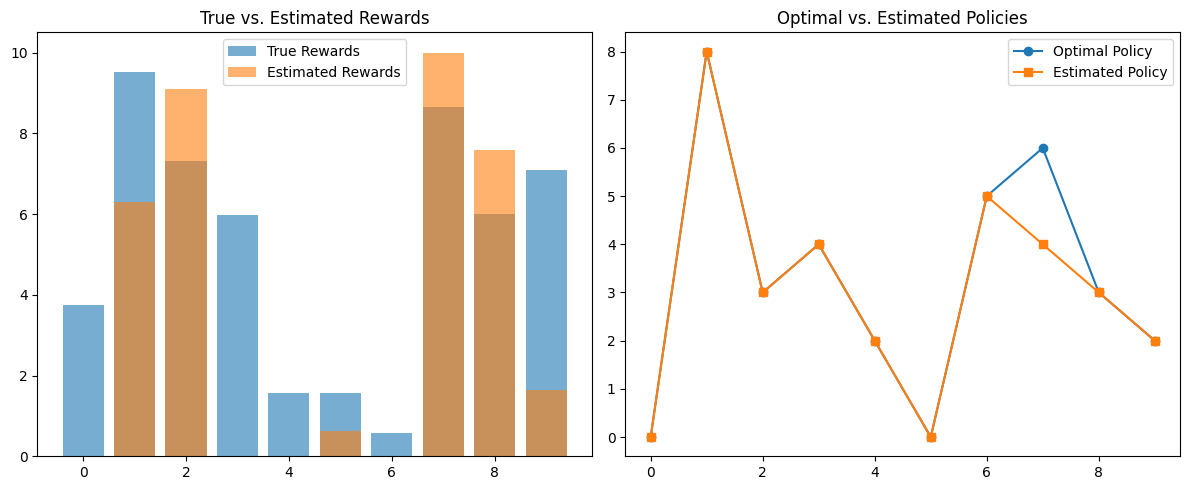

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv
from scipy.optimize import linprog

def finite_lp_irl(num_states, num_actions, transition_probabilities, discount_factor, max_reward, optimal_policy, regularization=0.0):
    P_opt = np.vstack([transition_probabilities[s, :, optimal_policy[s]] for s in range(num_states)])
    inv_matrix = inv(np.eye(num_states) - discount_factor * P_opt)

    def drop_in_value(action, state):
        delta_p = P_opt[state, :] - transition_probabilities[state, :, action]
        return delta_p @ inv_matrix

    num_variables = num_states * 2
    c = np.concatenate([-np.ones(num_states), regularization * np.ones(num_states)])
    A_ub, b_ub = [], []

    for s in range(num_states):
        for a in range(num_actions):
            if a != optimal_policy[s]:
                row = np.zeros(num_variables)
                row[s] = 1
                row[num_states:] = -drop_in_value(a, s)
                A_ub.append(row)
                b_ub.append(0)

    for s in range(num_states):
        for a in range(num_actions):
            row = np.zeros(num_variables)
            row[num_states:] = -drop_in_value(a, s)
            A_ub.append(row)
            b_ub.append(0)

    for s in range(num_states):
        row = np.zeros(num_variables)
        row[num_states + s] = 1
        A_ub.append(row)
        b_ub.append(max_reward)

    bounds = [(0, None)] * num_variables
    res = linprog(c, A_ub=np.array(A_ub), b_ub=np.array(b_ub), bounds=bounds, method='highs')

    if not res.success:
        raise ValueError("Optimization failed: " + res.message)

    z_est, R_est = res.x[:num_states], np.clip(res.x[num_states:], None, max_reward)
    V_est = inv_matrix @ R_est
    return R_est, V_est

def generate_random_mdp(num_states, num_actions, max_reward):
    R_true = np.random.uniform(0, max_reward, size=num_states)
    Pssa = np.zeros((num_states, num_states, num_actions))
    for s in range(num_states):
        for a in range(num_actions):
            probabilities = np.random.rand(num_states)
            probabilities /= probabilities.sum()
            Pssa[s, :, a] = probabilities
    return R_true, Pssa

def value_iteration(num_states, num_actions, rewards, transition_probabilities, discount_factor, epsilon=1e-6, max_iterations=1000):
    V, policy = np.zeros(num_states), np.zeros(num_states, dtype=int)
    for _ in range(max_iterations):
        V_prev, Q = V.copy(), np.zeros((num_states, num_actions))
        for s in range(num_states):
            for a in range(num_actions):
                Q[s, a] = rewards[s] + discount_factor * transition_probabilities[s, :, a] @ V_prev
        V, policy = np.max(Q, axis=1), np.argmax(Q, axis=1)
        if np.max(np.abs(V - V_prev)) < epsilon:
            break
    return V, policy

num_states, num_actions, discount_factor, max_reward, regularization = 10, 10, 0.9, 10.0, 0.1
np.random.seed(42)

R_true, Pssa = generate_random_mdp(num_states, num_actions, max_reward)
V_opt, policy_opt = value_iteration(num_states, num_actions, R_true, Pssa, discount_factor)
R_est, V_est = finite_lp_irl(num_states, num_actions, Pssa, discount_factor, max_reward, policy_opt, regularization)
V_est_opt, policy_est = value_iteration(num_states, num_actions, R_est, Pssa, discount_factor)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(range(num_states), R_true, alpha=0.6, label='True Rewards')
plt.bar(range(num_states), R_est, alpha=0.6, label='Estimated Rewards')
plt.title('True vs. Estimated Rewards')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_states), policy_opt, 'o-', label='Optimal Policy')
plt.plot(range(num_states), policy_est, 's-', label='Estimated Policy')
plt.title('Optimal vs. Estimated Policies')
plt.legend()

plt.tight_layout()
plt.show()